In [1]:
import sys
sys.path.append('D:\PyCharmProjects\VFPUMC02')
sys.path.append(r'C:\Users\Administrator\PycharmProjects\VFPUMC02')
sys.path.append(r'/root/VFPUMC02')
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [68]:
from datasets.DataSet import BankDataset
from utils.DataProcessUtils import (
    convert_columns_to_int,
    shuffle_column_order,
    vertical_split,
    constru_row_miss_df,
    get_discrete_columns,
    evaluate_imputed_data,
    find_rounds_math,
    stack_and_reset_index,
    process_dataframes
)
from consts.Constants import DATASETS_PATH
import os
from datasets.VFPU_GEN_DATASET import VFPU_GEN_DATASET
from enums.DataSetsName import DataSetsName
from ctgan import CTGAN
from classfiers.TwoStep import TwoStep
import pandas as pd
from vf4lr.VF_LR import VF_LR
from classfiers.VF_LinearRegression import VF_LinearRegression
from classfiers.VF_TwoStep import VF_TwoStep

In [3]:
dataset = VFPU_GEN_DATASET()

In [4]:
df_A, df_B, y = dataset.get_dataset_parts(DataSetsName.BANK.value)

In [5]:
miss_rate=0.2
complete_df_B, incomplete_df_B, missing_df_B = constru_row_miss_df(df_B, miss_rate)

全部用ctgan生成

In [6]:
ctgan = CTGAN(epochs=10)
discrete_columns = get_discrete_columns(incomplete_df_B)
ctgan.fit(incomplete_df_B,discrete_columns)
length=missing_df_B.shape[0]
# 生成数据
synthetic_data = ctgan.sample(length)

/root/miniconda3/envs/fate_env/lib/python3.10/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11060). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0
2025-01-23 17:51:55,788 - INFO - Guidance: There are no missing values in column nr.employed. Extra column not created.
2025-01-23 17:51:57,771 - INFO - Guidance: There are no missing values in column pdays. Extra column not created.
2025-01-23 17:51:58,213 - INFO - Guidance: There are no missing values in column previous. Extra column not created.


In [7]:
construct_df_B = stack_and_reset_index(incomplete_df_B, synthetic_data)

RMSE: 0.5783528432662717
MSE: 0.3344920113141806
MAE: 0.2193233935765138
R²: -1.4208250932037814


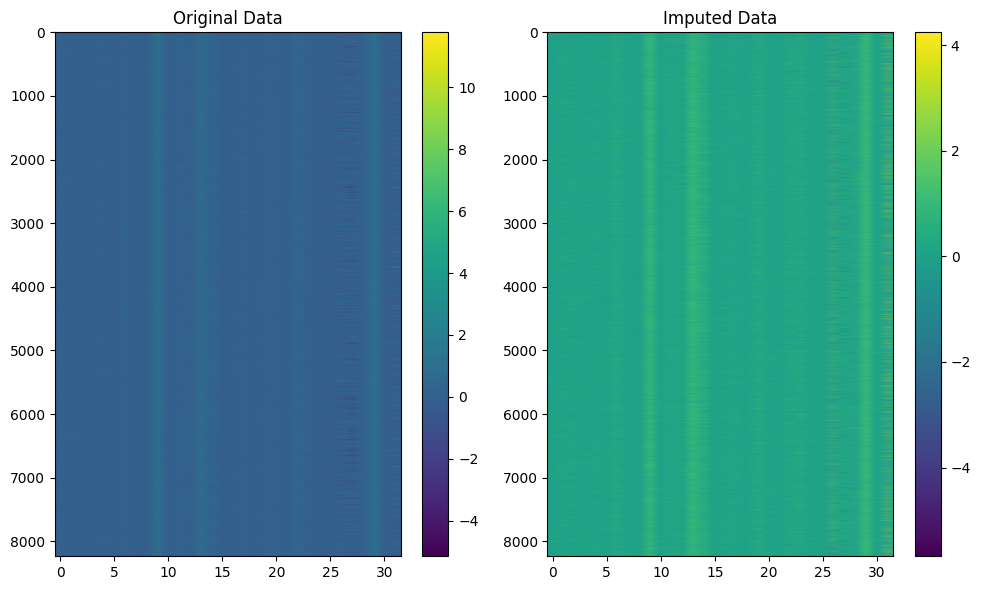

In [8]:
evaluate_imputed_data(missing_df_B.values, synthetic_data.values)

全部用半监督方法预测

In [9]:
unlabeled_row_indices = list(missing_df_B.index)
predict_cols = construct_df_B.columns

In [10]:
df_A_L, df_A_U, construct_df_B_L, construct_df_B_U, y_L_dict, y_U_dict, construct_df_B_L_train, construct_df_B_U_train = process_dataframes(df_A, construct_df_B, unlabeled_row_indices, predict_cols)

=== Logs ===
df_A_L: (32951, 31)
df_A_U: (8237, 31)
construct_df_B_L: (32951, 32)
construct_df_B_U: (8237, 32)
train_cols: []
y_L_dict keys: ['job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'loan_no', 'loan_unknown', 'loan_yes', 'marital_divorced', 'marital_married', 'marital_single', 'marital_unknown', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'nr.employed', 'pdays', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'previous']
y_U_dict keys: ['job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'loan_no', 'loan_unknown', 'loan_yes', 'marital_divorced', 'marital_married', 'marital_single', 'marital_unknown', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar'

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
clf =  LogisticRegression(solver='sag', max_iter=100)
reg =  Ridge(alpha=0.1, solver='sag', max_iter=100)

two_step = TwoStep(
    base_classifier=clf,
    base_regressor=reg,
    max_iter=100,
    k=0.1
)

2025-01-23 17:54:19,565 - ConsoleLogger - INFO - TwoStep 类已初始化: max_iter=100, k=0.10, base_classifier=LogisticRegression, base_regressor=Ridge
2025-01-23 17:54:19,565 - INFO - TwoStep 类已初始化: max_iter=100, k=0.10, base_classifier=LogisticRegression, base_regressor=Ridge


In [ ]:
y_pred_dict = {}
for key, y_L in y_L_dict.items():
    two_step.fit(df_A_L.values, y_L.values, df_A_U.values)
    y_pred = two_step.get_unlabeled_predict_by_label(y_L)
    y_pred_dict[key] = y_pred

2025-01-23 17:54:21,989 - ConsoleLogger - INFO - 有标签数据 (L): 32951 样本
2025-01-23 17:54:21,989 - INFO - 有标签数据 (L): 32951 样本
2025-01-23 17:54:21,990 - ConsoleLogger - INFO - 无标签数据 (U): 8237 样本
2025-01-23 17:54:21,990 - INFO - 无标签数据 (U): 8237 样本
2025-01-23 17:54:21,991 - ConsoleLogger - INFO - 任务类型判定结果: classification
2025-01-23 17:54:21,991 - INFO - 任务类型判定结果: classification
2025-01-23 17:54:21,992 - ConsoleLogger - INFO - 这是一个分类任务。
2025-01-23 17:54:21,992 - INFO - 这是一个分类任务。
2025-01-23 17:54:21,996 - ConsoleLogger - INFO - 分类任务中的类别: [0 1]
2025-01-23 17:54:21,996 - INFO - 分类任务中的类别: [0 1]
2025-01-23 17:54:21,998 - ConsoleLogger - INFO - 初始化预测结果数组，长度=8237
2025-01-23 17:54:21,998 - INFO - 初始化预测结果数组，长度=8237
2025-01-23 17:54:21,999 - ConsoleLogger - INFO - 开始自训练迭代，共计划进行 100 次迭代
2025-01-23 17:54:21,999 - INFO - 开始自训练迭代，共计划进行 100 次迭代
2025-01-23 17:54:22,000 - ConsoleLogger - INFO - ===== 第 0 次迭代开始 =====
2025-01-23 17:54:22,000 - INFO - ===== 第 0 次迭代开始 =====
2025-01-23 17:54:22,000 - ConsoleLogger 

In [22]:
synthetic_data_gen_all = pd.DataFrame(y_pred_dict)

In [26]:
synthetic_data_gen_all = synthetic_data_gen_all[incomplete_df_B.columns]

In [28]:
synthetic_data_gen_all.shape

(8237, 32)

In [29]:
missing_df_B.shape

(8237, 32)

RMSE: 0.33421078342174504
MSE: 0.11169684775537657
MAE: 0.09096496327198114
R²: 0.17242153861967155


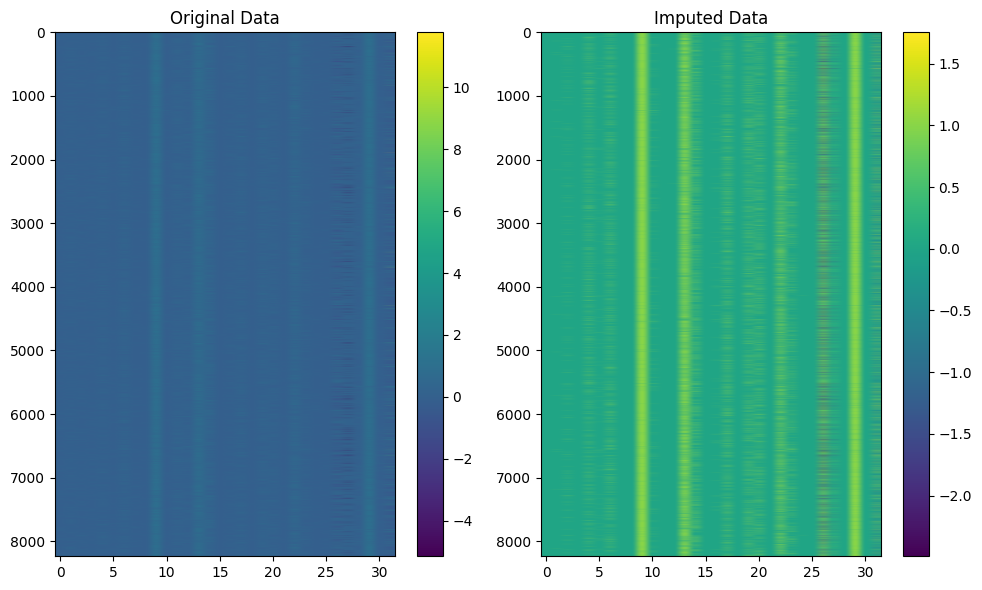

In [31]:
evaluate_imputed_data(missing_df_B.values, synthetic_data_gen_all)

生成 k 列
预测 m - k 列

In [52]:
m = incomplete_df_B.shape[1]
for k in range(m+1):
    predict_cols = construct_df_B.columns[0:m-k]
    print(predict_cols)

Index(['job_housemaid', 'job_management', 'job_retired', 'job_self-employed',
       'job_services', 'job_student', 'job_technician', 'job_unemployed',
       'job_unknown', 'loan_no', 'loan_unknown', 'loan_yes',
       'marital_divorced', 'marital_married', 'marital_single',
       'marital_unknown', 'month_apr', 'month_aug', 'month_dec', 'month_jul',
       'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct',
       'month_sep', 'nr.employed', 'pdays', 'poutcome_failure',
       'poutcome_nonexistent', 'poutcome_success', 'previous'],
      dtype='object')
Index(['job_housemaid', 'job_management', 'job_retired', 'job_self-employed',
       'job_services', 'job_student', 'job_technician', 'job_unemployed',
       'job_unknown', 'loan_no', 'loan_unknown', 'loan_yes',
       'marital_divorced', 'marital_married', 'marital_single',
       'marital_unknown', 'month_apr', 'month_aug', 'month_dec', 'month_jul',
       'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oc

In [53]:
k = 1
unlabeled_row_indices = list(missing_df_B.index)
predict_cols = construct_df_B.columns[0:m-k]

In [70]:
df_A_L, df_A_U, construct_df_B_L, construct_df_B_U, y_L_dict, y_U_dict, construct_df_B_L_train, construct_df_B_U_train = process_dataframes(df_A, construct_df_B, unlabeled_row_indices, predict_cols)

=== Logs ===
df_A_L: (32951, 31)
df_A_U: (8237, 31)
construct_df_B_L: (32951, 32)
construct_df_B_U: (8237, 32)
train_cols: ['previous']
y_L_dict keys: ['job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'loan_no', 'loan_unknown', 'loan_yes', 'marital_divorced', 'marital_married', 'marital_single', 'marital_unknown', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'nr.employed', 'pdays', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success']
y_U_dict keys: ['job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'loan_no', 'loan_unknown', 'loan_yes', 'marital_divorced', 'marital_married', 'marital_single', 'marital_unknown', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 

In [60]:
vf_clf = VF_LR(
    learning_rate=0.2,
    epoch_num=100,
    batch_size=64
)
vf_reg = VF_LinearRegression(
    config={
    'lr': 0.01,
    'lambda': 0.1,
    'n_iters':100
    }
)

2025-01-23 19:46:56,999 - ConsoleLogger - INFO - VF_LR 模型初始化完成。
2025-01-23 19:46:56,999 - INFO - VF_LR 模型初始化完成。
2025-01-23 19:46:57,001 - ConsoleLogger - INFO - 模型配置: {'learning_rate': 0.2, 'epoch_num': 100, 'batch_size': 64, 'client_num': 2}
2025-01-23 19:46:57,001 - INFO - 模型配置: {'learning_rate': 0.2, 'epoch_num': 100, 'batch_size': 64, 'client_num': 2}
2025-01-23 19:46:57,002 - ConsoleLogger - INFO - VF_LinearRegression 模型初始化完成。
2025-01-23 19:46:57,002 - INFO - VF_LinearRegression 模型初始化完成。
2025-01-23 19:46:57,002 - ConsoleLogger - INFO - 模型配置: {'lr': 0.01, 'lambda': 0.1, 'n_iters': 100}
2025-01-23 19:46:57,002 - INFO - 模型配置: {'lr': 0.01, 'lambda': 0.1, 'n_iters': 100}


In [65]:
vf_two_step = VF_TwoStep(
    clf=vf_clf,
    reg=vf_reg,
    k=0.1,
    max_iter=100
)

2025-01-23 19:55:01,439 - INFO - VF_TwoStep 类已成功初始化: max_iter=100, k=0.10, min_confidence=0.00, convergence_threshold=0, clf=VF_LR, reg=VF_LinearRegression


In [ ]:
y_pred_dict = {}
for key, y_L in y_L_dict.items():
    vf_two_step.fit(
    XA_L=df_A_L.values,
    XB_L=construct_df_B_L_train.values,
    y_L=y_L,
    XA_U=df_A_U.values,
    XB_U=construct_df_B_U_train.values
    )
    y_pred = vf_two_step.get_unlabeled_predict_by_label(y_L)
    y_pred_dict[key] = y_pred